### Pre-process step 5
- Read TTL file and generate master image and behavior timestamps
- Extract behavior events from json file saved with bonsai
- Align behavior events to fiber photometry data from step 3
- Extract rewarded and unrewarded trials and other interesting parameters

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import csv
import h5py
import json

Paths are for dataset tagged: all


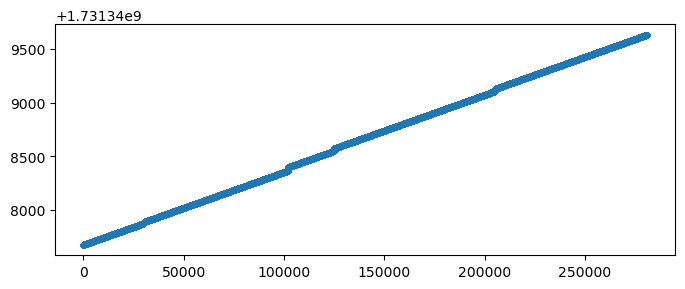

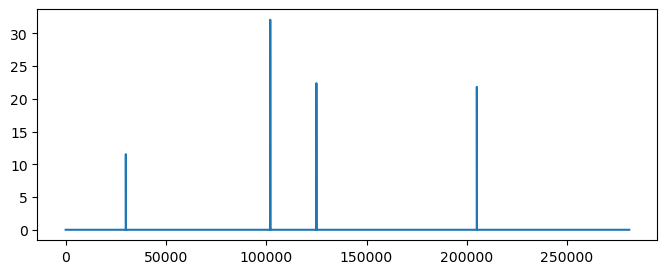

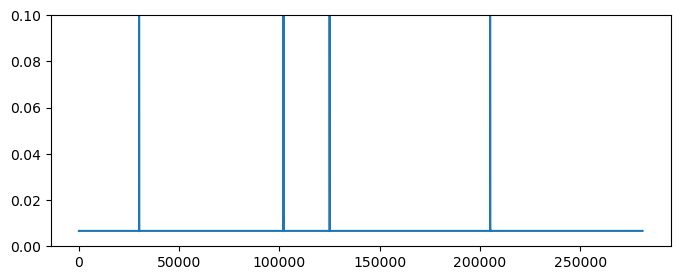

In [2]:
# Load HSFP preprocessed hdf5 file 
f = h5py.File(paths['raw_data'] / 'fib\hsfp_data_preprocessed.hdf5','r')
time_405 = np.array(f['Time_405'])
time_445 = np.array(f['Time_445'])
time_473 = np.array(f['Time_473'])
time_514 = np.array(f['Time_514'])
time_560 = np.array(f['Time_560'])
timestamps = np.array(f['Full_TimeStamps'])
lasers = np.array(f['Lasers'])
wavelength = np.array(f['Wavelength'])
L_405_F1 = np.array(f['Channel_405_F1'])
L_405_F2 = np.array(f['Channel_405_F2'])
L_445_F1 = np.array(f['Channel_445_F1'])
L_445_F2 = np.array(f['Channel_445_F2'])
L_473_F1 = np.array(f['Channel_473_F1'])
L_473_F2 = np.array(f['Channel_473_F2'])
L_514_F1 = np.array(f['Channel_514_F1'])
L_514_F2 = np.array(f['Channel_514_F2'])
L_560_F1 = np.array(f['Channel_560_F1'])
L_560_F2 = np.array(f['Channel_560_F2'])
# Plot figure with camTrigger 
plt.figure(figsize=(8,3))
plt.plot(timestamps,'.')
plt.show()
plt.figure(figsize=(8,3))
plt.plot(np.diff(timestamps))
plt.show()
plt.figure(figsize=(8,3))
plt.plot(np.diff(timestamps))
plt.ylim(0,0.1)
plt.show()


In [3]:
# Read harp event file for the timing input from the hamamatsu camera

from datetime import datetime
from enum import IntEnum
from os import PathLike
from typing import Any, BinaryIO, Optional, Union

import numpy as np
import pandas as pd
from pandas._typing import Axes

REFERENCE_EPOCH = datetime(1904, 1, 1)
"""The reference epoch for UTC harp time."""


class MessageType(IntEnum):
    """Specifies the type of a Harp message."""

    NA = 0
    READ = 1
    WRITE = 2
    EVENT = 3


_SECONDS_PER_TICK = 32e-6
_messagetypes = [type.name for type in MessageType]
_payloadtypes = {
    1: np.dtype(np.uint8),
    2: np.dtype(np.uint16),
    4: np.dtype(np.uint32),
    8: np.dtype(np.uint64),
    129: np.dtype(np.int8),
    130: np.dtype(np.int16),
    132: np.dtype(np.int32),
    136: np.dtype(np.int64),
    68: np.dtype(np.float32),
}

def read(
    file: Union[str, bytes, PathLike[Any], BinaryIO],
    address: Optional[int] = None,
    dtype: Optional[np.dtype] = None,
    length: Optional[int] = None,
    columns: Optional[Axes] = None,
    epoch: Optional[datetime] = None,
    keep_type: bool = False,
):
    """Read single-register Harp data from the specified file.

    Parameters
    ----------
    file
        Open file object or filename containing binary data from
        a single device register.
    address
        Expected register address. If specified, the address of
        the first message in the file is used for validation.
    dtype
        Expected data type of the register payload. If specified, the
        payload type of the first message in the file is used for validation.
    length
        Expected number of elements in register payload. If specified, the
        payload length of the first message in the file is used for validation.
    columns
        The optional column labels to use for the data values.
    epoch
        Reference datetime at which time zero begins. If specified,
        the result data frame will have a datetime index.
    keep_type
        Specifies whether to include a column with the message type.

    Returns
    -------
        A pandas data frame containing message data, sorted by time.
    """
    data = np.fromfile(file, dtype=np.uint8)
    if len(data) == 0:
        return pd.DataFrame(columns=columns, index=pd.Index([], dtype=np.float64, name="Time"))

    if address is not None and address != data[2]:
        raise ValueError(f"expected address {address} but got {data[2]}")

    index = None
    stride = int(data[1] + 2)
    nrows = len(data) // stride
    payloadtype = data[4]
    payloadoffset = 5
    if payloadtype & 0x10 != 0:
        seconds = np.ndarray(nrows, dtype=np.uint32, buffer=data, offset=payloadoffset, strides=stride)
        payloadoffset += 4
        micros = np.ndarray(nrows, dtype=np.uint16, buffer=data, offset=payloadoffset, strides=stride)
        payloadoffset += 2
        time = micros * _SECONDS_PER_TICK + seconds
        payloadtype = payloadtype & ~np.uint8(0x10)
        if epoch is not None:
            time = epoch + pd.to_timedelta(time, "s")  # type: ignore
        index = pd.Series(time)
        index.name = "Time"

    payloadsize = stride - payloadoffset - 1
    payloadtype = _payloadtypes[payloadtype]
    if dtype is not None and dtype != payloadtype:
        raise ValueError(f"expected payload type {dtype} but got {payloadtype}")

    elementsize = payloadtype.itemsize
    payloadshape = (nrows, payloadsize // elementsize)
    if length is not None and length != payloadshape[1]:
        raise ValueError(f"expected payload length {length} but got {payloadshape[1]}")

    payload = np.ndarray(
        payloadshape,
        dtype=payloadtype,
        buffer=data,
        offset=payloadoffset,
        strides=(stride, elementsize),
    )

    result = pd.DataFrame(payload, index=index, columns=columns)
    if keep_type:
        msgtype = np.ndarray(nrows, dtype=np.uint8, buffer=data, offset=0, strides=stride)
        msgtype = pd.Categorical.from_codes(msgtype, categories=_messagetypes)  # type: ignore
        result[MessageType.__name__] = msgtype
    return result

# Read the binary file as a data frame
data_frame = read(paths['raw_data'] / 'behavior\\raw.harp\\BehaviorEvents\\Event_32.bin')

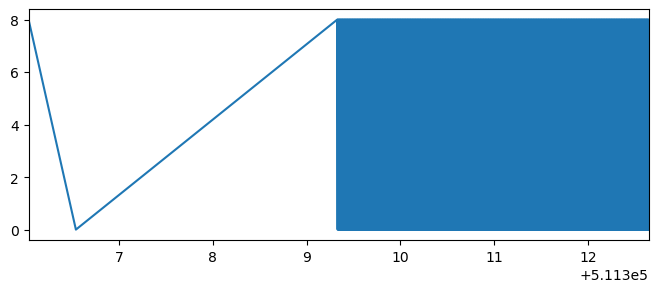

[8 0 8 ... 0 8 0]
[5.04576000e-01 2.78736000e+00 4.03200003e-03 ... 4.00000002e-03
 2.65599997e-03 4.00000002e-03]
First occurrence of the pattern:
Start index: 2, Stop index: 5
Last occurrence of the pattern:
Start index: 580268, Stop index: 580271
Camera trigger time: 511309.325984
Camera trigger time: 3.291935999994166 sec


In [4]:
# Convert the event data to numpy arrays and find the camera trigger start time

event_times = np.array(data_frame.index)
event_values = np.array(data_frame[0])

# Plot the event data
plt.figure(figsize=(8,3))
plt.plot(event_times, event_values)
plt.xlim(event_times[0], event_times[1000])
plt.show()


print(event_values)
d = (np.diff(event_times))
print(d)

# Define your vector
x = d #np.array([0.5, 2.7, 3.99, 2.66, 4.01, 2.66, 4, 2.66, 9, 10, 11])

# Define the target pattern with tolerance
target_pattern = [0.004, 0.00266, 0.004, 0.00266]
tolerance = 0.0001  # Define a tolerance for the matching

# Function to check if values match the pattern within tolerance
def matches_pattern(sub_array, pattern, tol):
    return all(np.isclose(sub_array[i], pattern[i], atol=tol) for i in range(len(pattern)))

# Initialize variables for first and last occurrence
first_start_index, first_stop_index = None, None
last_start_index, last_stop_index = None, None

# Loop through the vector to find the first and last occurrences
for i in range(len(x) - len(target_pattern) + 1):
    # Check if the slice of x matches the pattern within the tolerance
    if matches_pattern(x[i:i+len(target_pattern)], target_pattern, tolerance):
        # For the first occurrence, set the start and stop indices
        if first_start_index is None:
            first_start_index = i
            first_stop_index = i + len(target_pattern) - 1
        # Update the last occurrence each time a match is found
        last_start_index = i
        last_stop_index = i + len(target_pattern) - 1

# Print the results
if first_start_index is not None and last_start_index is not None:
    print("First occurrence of the pattern:")
    print(f"Start index: {first_start_index}, Stop index: {first_stop_index}")
    print("Last occurrence of the pattern:")
    print(f"Start index: {last_start_index}, Stop index: {last_stop_index}")
else:
    print("Pattern not found")\
    
camera_trigger_index = first_start_index
camera_trigger_time = event_times[camera_trigger_index]
print(f"Camera trigger time: {camera_trigger_time}")
print(f"Camera trigger time: {camera_trigger_time-event_times[0]} sec")

In [5]:
# Find where the camera trigger is in the harp time

# Example: time vector on clock 1 (in seconds, for instance)
clock1_times = timestamps  # Replace with your actual clock 1 time vector
# Calculate the time differences between consecutive frames on clock 1
time_diffs = np.diff(clock1_times)
# Start time for clock 2
clock2_start_time = camera_trigger_time  # Replace with your actual start time on clock 2
# Generate clock 2 times by adding cumulative sum of time differences to start time
harp_timestamps = np.insert(np.cumsum(time_diffs), 0, 0) + clock2_start_time
print(harp_timestamps)

# Generate the timestamp for each laser from the hsfp times

def convert_hsfp_to_harp_time(hsfp_timestamps, harp_timestamps, hsfp_time):
    """
    Converts HSFP timestamps to Harp timestamps.
    Parameters:
    hsfp_timestamps (np.array): The HSFP timestamps.
    harp_timestamps (np.array): The Harp timestamps.
    hsfp_time (float): The HSFP time to convert.
    Returns:
    float: The Harp time.
    """
    harp_time = np.zeros(len(hsfp_time))
    for i in range(len(hsfp_time)):
        # Find the index of the closest HSFP timestamp
        hsfp_index = np.searchsorted(hsfp_timestamps, hsfp_time[i])
        harp_time[i] = harp_timestamps[hsfp_index]
    return harp_time

# Convert each laser hsfp time to harp time
harp_time_405 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_405)
harp_time_445 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_445)
harp_time_473 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_473)
harp_time_514 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_514)
harp_time_560 = convert_hsfp_to_harp_time(timestamps, harp_timestamps, time_560)


[511309.325984   511309.33263993 511309.33929491 ... 513267.46516585
 513267.47182083 513267.47847581]


In [6]:
# Detrent the hsfp data with a 4th order polynomial

def detrend_signal(signal):
    x = np.arange(len(signal))
    p = np.polyfit(x,signal,5)
    y = np.polyval(p,x)
    signal_detrended = signal - y + np.mean(signal)
    return signal_detrended

L_405_F1_detrend = np.zeros(np.shape(L_405_F1))
L_405_F2_detrend = np.zeros(np.shape(L_405_F2))
L_445_F1_detrend = np.zeros(np.shape(L_445_F1))
L_445_F2_detrend = np.zeros(np.shape(L_445_F2))
L_473_F1_detrend = np.zeros(np.shape(L_473_F1))
L_473_F2_detrend = np.zeros(np.shape(L_473_F2))
L_514_F1_detrend = np.zeros(np.shape(L_514_F1))
L_514_F2_detrend = np.zeros(np.shape(L_514_F2))
L_560_F1_detrend = np.zeros(np.shape(L_560_F1))
L_560_F2_detrend = np.zeros(np.shape(L_560_F2))
for i in range(len(L_560_F2[0,:])):
    L_405_F1_detrend[:,i] = detrend_signal(L_405_F1[:,i])
    L_405_F2_detrend[:,i] = detrend_signal(L_405_F2[:,i])
    L_445_F1_detrend[:,i] = detrend_signal(L_445_F1[:,i])
    L_445_F2_detrend[:,i] = detrend_signal(L_445_F2[:,i])
    L_473_F1_detrend[:,i] = detrend_signal(L_473_F1[:,i])
    L_473_F2_detrend[:,i] = detrend_signal(L_473_F2[:,i])
    L_514_F1_detrend[:,i] = detrend_signal(L_514_F1[:,i])
    L_514_F2_detrend[:,i] = detrend_signal(L_514_F2[:,i])
    L_560_F1_detrend[:,i] = detrend_signal(L_560_F1[:,i])
    L_560_F2_detrend[:,i] = detrend_signal(L_560_F2[:,i])

# Calculate z-scores for each detrended trace
z_405_F1 = (L_405_F1_detrend - np.mean(L_405_F1_detrend,axis=0))/np.std(L_405_F1_detrend,axis=0)
z_405_F2 = (L_405_F2_detrend - np.mean(L_405_F2_detrend,axis=0))/np.std(L_405_F2_detrend,axis=0)
z_445_F1 = (L_445_F1_detrend - np.mean(L_445_F1_detrend,axis=0))/np.std(L_445_F1_detrend,axis=0)
z_445_F2 = (L_445_F2_detrend - np.mean(L_445_F2_detrend,axis=0))/np.std(L_445_F2_detrend,axis=0)
z_473_F1 = (L_473_F1_detrend - np.mean(L_473_F1_detrend,axis=0))/np.std(L_473_F1_detrend,axis=0)
z_473_F2 = (L_473_F2_detrend - np.mean(L_473_F2_detrend,axis=0))/np.std(L_473_F2_detrend,axis=0)
z_514_F1 = (L_514_F1_detrend - np.mean(L_514_F1_detrend,axis=0))/np.std(L_514_F1_detrend,axis=0)
z_514_F2 = (L_514_F2_detrend - np.mean(L_514_F2_detrend,axis=0))/np.std(L_514_F2_detrend,axis=0)
z_560_F1 = (L_560_F1_detrend - np.mean(L_560_F1_detrend,axis=0))/np.std(L_560_F1_detrend,axis=0)
z_560_F2 = (L_560_F2_detrend - np.mean(L_560_F2_detrend,axis=0))/np.std(L_560_F2_detrend,axis=0)

# # Calculate deltaF/F for each detrended trace
# dF_F_405_F1 = ((L_405_F1_detrend/np.mean(L_405_F1_detrend,axis=0))-1)*100
# dF_F_405_F2 = ((L_405_F2_detrend/np.mean(L_405_F2_detrend,axis=0))-1)*100
# dF_F_445_F1 = ((L_445_F1_detrend/np.mean(L_445_F1_detrend,axis=0))-1)*100
# dF_F_445_F2 = ((L_445_F2_detrend/np.mean(L_445_F2_detrend,axis=0))-1)*100
# dF_F_473_F1 = ((L_473_F1_detrend/np.mean(L_473_F1_detrend,axis=0))-1)*100
# dF_F_473_F2 = ((L_473_F2_detrend/np.mean(L_473_F2_detrend,axis=0))-1)*100
# dF_F_514_F1 = ((L_514_F1_detrend/np.mean(L_514_F1_detrend,axis=0))-1)*100
# dF_F_514_F2 = ((L_514_F2_detrend/np.mean(L_514_F2_detrend,axis=0))-1)*100
# dF_F_560_F1 = ((L_560_F1_detrend/np.mean(L_560_F1_detrend,axis=0))-1)*100
# dF_F_560_F2 = ((L_560_F2_detrend/np.mean(L_560_F2_detrend,axis=0))-1)*100



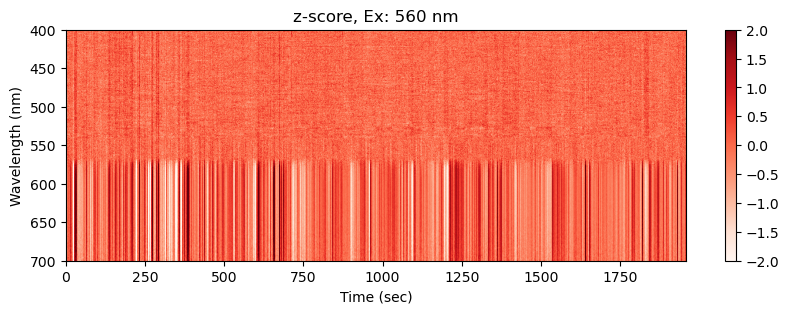

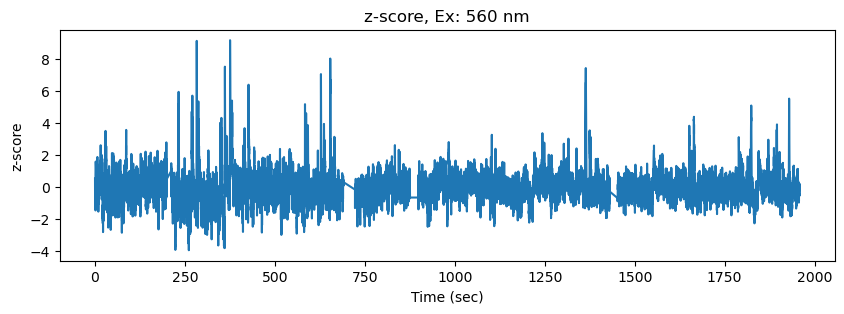

In [7]:
# Plot spectrogram of wavelength over time

# plt.figure(figsize=(10,3))
# t = harp_time_560-harp_time_560[0]
# plt.imshow(np.transpose(dF_F_560_F2),aspect='auto',cmap='Reds',vmin=-5,vmax=5,extent=[t[0],t[-1],700,400])
# plt.colorbar()
# plt.xlabel('Time (sec)')
# plt.ylabel('Wavelength (nm)')


plt.figure(figsize=(10,3))
t = harp_time_560-harp_time_560[0]
plt.imshow(np.transpose(z_560_F2),aspect='auto',cmap='Reds',vmin=-2,vmax=2,extent=[t[0],t[-1],700,400])
plt.colorbar()
plt.xlabel('Time (sec)')
plt.ylabel('Wavelength (nm)')
plt.title('z-score, Ex: 560 nm')

plt.figure(figsize=(10,3))
plt.plot(harp_time_560-harp_time_560[0],z_560_F1[:,600-400])
plt.xlabel('Time (sec)')
plt.ylabel('z-score')
plt.title('z-score, Ex: 560 nm')
plt.show()


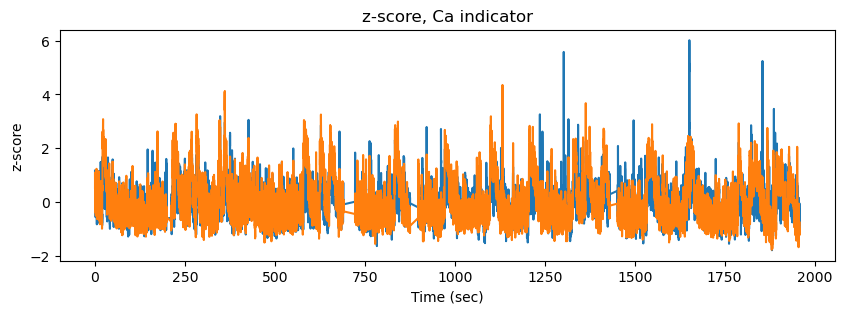

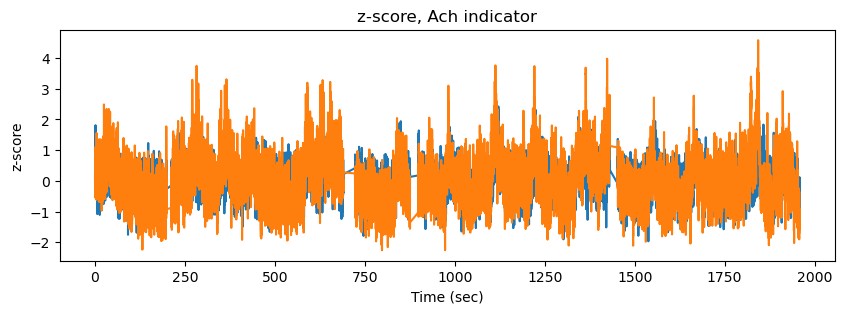

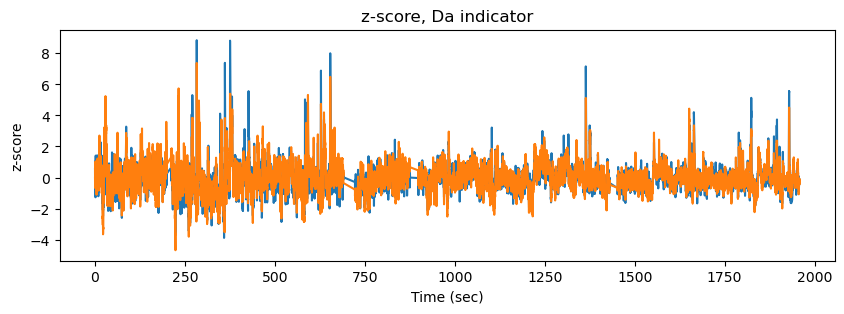

In [8]:
# Pull out ranges for indicator data

Ca_F1 = np.mean(z_473_F1[:,490-400:505-400], axis=1)
Ca_F2 = np.mean(z_473_F2[:,490-400:505-400], axis=1)
Ach_F1 = np.mean(z_514_F1[:,525-400:535-400], axis=1)
Ach_F2 = np.mean(z_514_F2[:,525-400:535-400], axis=1)
Da_F1 = np.mean(z_560_F1[:,590-400:610-400], axis=1)
Da_F2 = np.mean(z_560_F2[:,590-400:610-400], axis=1)

# Plot indicator data

plt.figure(figsize=(10,3))
plt.plot(harp_time_473-harp_time_473[0],Ca_F1)
plt.plot(harp_time_473-harp_time_473[0],Ca_F2)
plt.xlabel('Time (sec)')
plt.ylabel('z-score')
plt.title('z-score, Ca indicator')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(harp_time_514-harp_time_514[0],Ach_F1)
plt.plot(harp_time_514-harp_time_514[0],Ach_F2)
plt.xlabel('Time (sec)')
plt.ylabel('z-score')
plt.title('z-score, Ach indicator')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(harp_time_560-harp_time_560[0],Da_F1)
plt.plot(harp_time_560-harp_time_560[0],Da_F2)
plt.xlabel('Time (sec)')
plt.ylabel('z-score')
plt.title('z-score, Da indicator')
plt.show()



In [9]:
# Load behavior data video data

# Load behavior timestamps
behavior_time_path = [paths['raw_data'] / 'behavior-videos\side_camera_right.csv']
timestamps = np.genfromtxt(behavior_time_path[0], delimiter=',', dtype=None, encoding=None)
behavior_time = timestamps['f0']

# Load motion data
motion_path = [paths['raw_data'] / 'fib\whisker_motion.csv']
motion_data = np.genfromtxt(motion_path[0], delimiter=',', dtype=None, encoding=None)

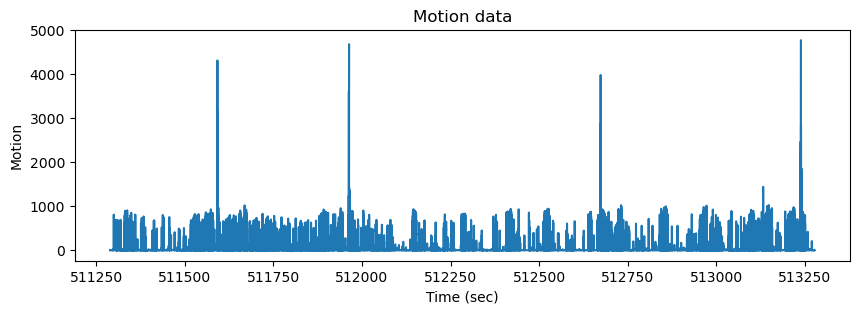

In [10]:
# Plot motion data

plt.figure(figsize=(10,3))
plt.plot(behavior_time, motion_data)
plt.xlabel('Time (sec)')
plt.ylabel('Motion')
plt.title('Motion data')
plt.show()

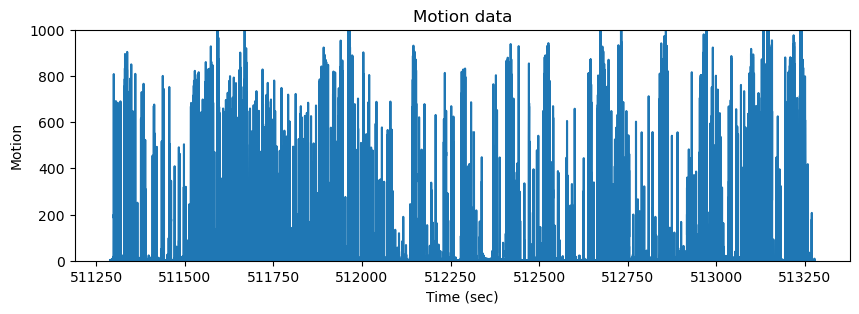

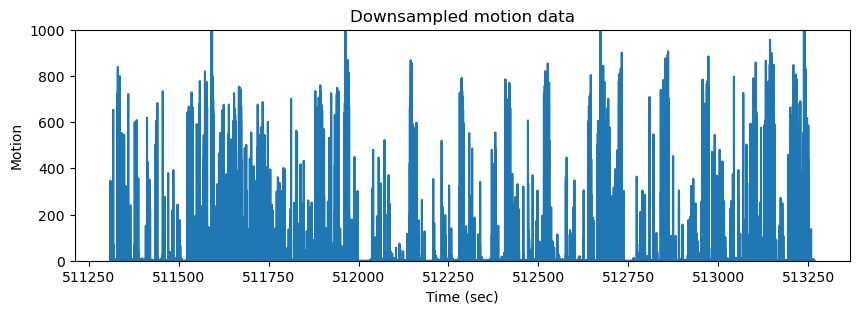

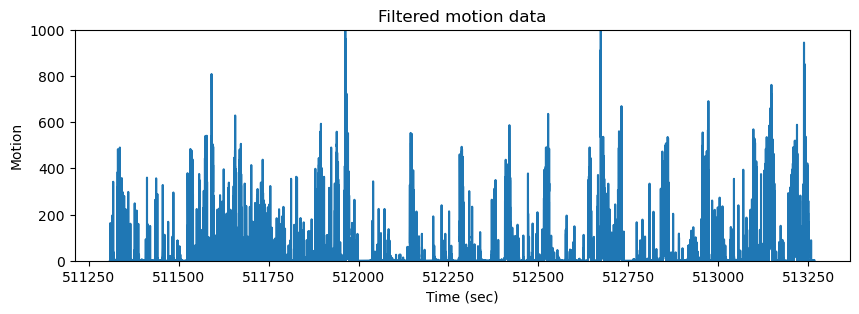

In [11]:
# Downsample the motion data to match the harp time

def downsample_motion_data(behavior_time, motion_data, harp_time):
    """
    Downsamples the motion data to match the harp time.
    Parameters:
    behavior_time (np.array): The behavior timestamps.
    motion_data (np.array): The motion data.
    harp_time (np.array): The harp timestamps.
    Returns:
    np.array: The downsampled motion data.
    """
    # Interpolate the motion data
    f = interp1d(behavior_time, motion_data, kind='linear')
    motion_data_downsampled = f(harp_time)
    return motion_data_downsampled

motion_data_downsampled = downsample_motion_data(behavior_time, motion_data, harp_time_560)

# Plot the downsampled motion data

plt.figure(figsize=(10,3))
plt.plot(behavior_time, motion_data)
plt.xlabel('Time (sec)')
plt.ylabel('Motion')
plt.title('Motion data')
plt.ylim(0,1000)
#plt.xlim(514250,514500)
plt.show()

plt.figure(figsize=(10,3))
plt.plot(harp_time_560, motion_data_downsampled)
plt.xlabel('Time (sec)')
plt.ylabel('Motion')
plt.title('Downsampled motion data')
plt.ylim(0,1000)
#plt.xlim(514250,514500)
plt.show()


# Low pass filter the motion data

from scipy.signal import butter, filtfilt

def low_pass_filter(data, cutoff_freq, fs):
    """
    Applies a low-pass filter to the data.
    Parameters:
    data (np.array): The data to filter.
    cutoff_freq (float): The cutoff frequency for the filter.
    fs (float): The sampling frequency.
    Returns:
    np.array: The filtered data.
    """
    # Normalize the cutoff frequency
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    # Apply the filter
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

motion_data_filtered = low_pass_filter(motion_data_downsampled, 5, 30.5)

# Plot the filtered motion data

plt.figure(figsize=(10,3))
plt.plot(harp_time_560, motion_data_filtered)
plt.xlabel('Time (sec)')
plt.ylabel('Motion')
plt.title('Filtered motion data')
plt.ylim(0,1000)
#plt.xlim(514250,514500)
plt.show()



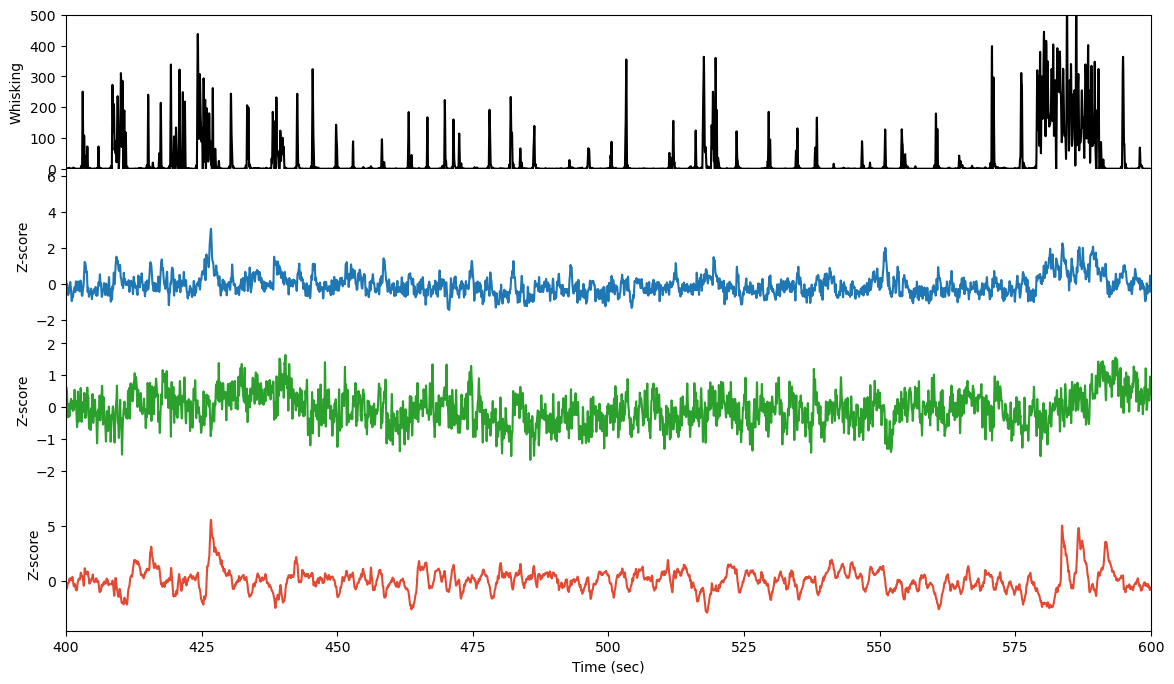

In [12]:
# Plot motion data with indicators

# set figure size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(14,8), gridspec_kw={'hspace': 0})  # hspace=0 removes vertical space

ax1.plot(harp_time_560-harp_time_560[0], motion_data_filtered, color='black')
# Remove x-axis from the first plot to avoid duplicate x-axis labels
ax1.get_xaxis().set_visible(False)
#ax1.get_yaxis().set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('Whisking')

ax2.spines['top'].set_visible(False)
ax2.plot(harp_time_473-harp_time_473[0],Ca_F1,color='#1f77b4')
ax2.get_xaxis().set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_ylabel('Z-score')

ax3.plot(harp_time_514-harp_time_514[0],Ach_F1,color='#2ca02c')
ax3.get_xaxis().set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.set_ylabel('Z-score')

ax4.plot(harp_time_560-harp_time_560[0],Da_F1,color='#e34a33')
ax4.spines['top'].set_visible(False)
ax4.set_xlabel('Time (sec)')
ax4.set_ylabel('Z-score')

ax1.set_ylim(0, 500)
# for ax in (ax2, ax3, ax4):
#     ax.set_ylim(-3, 4)
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(400, 600)

# Adjust layout to remove any extra margin around the subplots
#plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0)

plt.show()

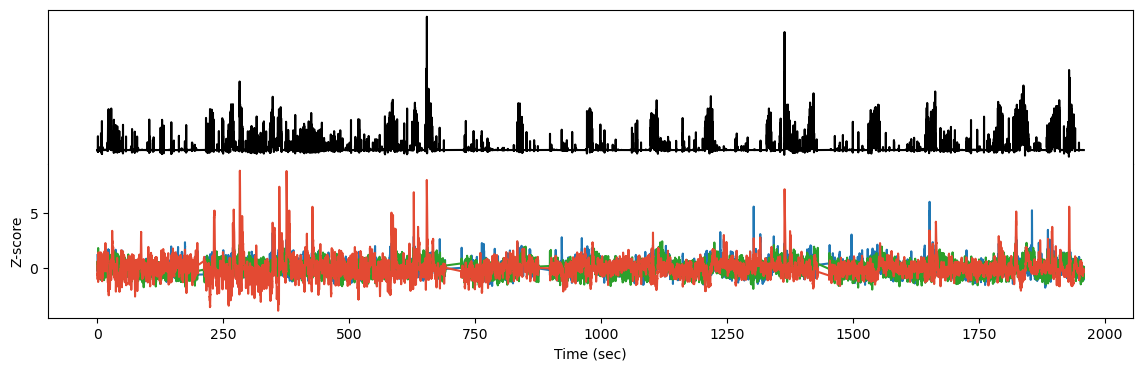

In [13]:
# Plot motion data with indicators

# set figure size
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14,4), gridspec_kw={'hspace': 0})  # hspace=0 removes vertical space

ax1.plot(harp_time_560-harp_time_560[0], motion_data_filtered, color='black')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.plot(harp_time_473-harp_time_473[0],Ca_F1,color='#1f77b4')
ax2.plot(harp_time_514-harp_time_514[0],Ach_F1,color='#2ca02c')
ax2.plot(harp_time_560-harp_time_560[0],Da_F1,color='#e34a33')

# ax1.set_ylim(0, 500)
# for ax in (ax1, ax2):
#     ax.set_ylim(-3, 4.5)
# for ax in (ax1, ax2):
#     ax.set_xlim(1370, 1620)
ax2.set_xlabel('Time (sec)')
ax2.set_ylabel('Z-score')

plt.show()

In [14]:
# Correlation between motion and indicators

# Remove outlier motion values

motion_data_filtered[motion_data_filtered > 1000] = 500


from scipy.stats import pearsonr

def calculate_correlation(motion_data, indicator_data):
    """
    Calculates the correlation between motion and indicator data.
    Parameters:
    motion_data (np.array): The motion data.
    indicator_data (np.array): The indicator data.
    Returns:
    float: The correlation coefficient.
    """
    correlation, _ = pearsonr(motion_data, indicator_data)
    return correlation

start = 0
stop = 48000
whisking = motion_data_filtered[start:stop]/np.mean(motion_data_filtered[start:stop])
correlation_Ca = calculate_correlation(whisking, Ca_F2[start:stop])
correlation_Ach = calculate_correlation(whisking, Ach_F2[start:stop])
correlation_Da = calculate_correlation(whisking, Da_F2[start:stop])

print(f"Correlation between motion and Ca indicator: {correlation_Ca}")
print(f"Correlation between motion and Ach indicator: {correlation_Ach}")
print(f"Correlation between motion and Da indicator: {correlation_Da}")



Correlation between motion and Ca indicator: 0.662778352362347
Correlation between motion and Ach indicator: 0.217099985664834
Correlation between motion and Da indicator: -0.12619035017456245


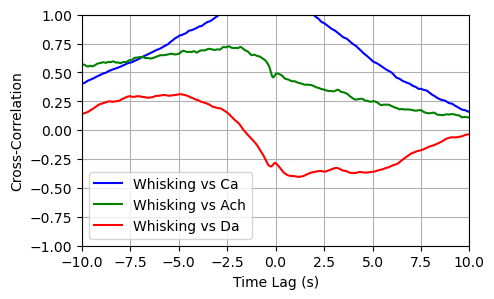

In [ ]:
# Cross-correlation between motion and indicators

# Calculate the cross correlation between Ca, Ach, and Da

from scipy.signal import correlate

# Calculate the cross-correlation between motion and Ca
cross_corr_Ca = correlate(motion_data_filtered/np.mean(motion_data_filtered), Ca_F2, mode='full')
n = len(Ca_F1)
cross_corr_Ca = cross_corr_Ca / n
# Calculate the cross-correlation between motion and Ach
cross_corr_Ach = correlate(motion_data_filtered/np.mean(motion_data_filtered), Ach_F2, mode='full')
n = len(Ach_F1)
cross_corr_Ach = cross_corr_Ach / n
# Calculate the cross-correlation between motion and Da
cross_corr_Da = correlate(motion_data_filtered/np.mean(motion_data_filtered), Da_F2, mode='full')
n = len(Da_F1)
cross_corr_Da = cross_corr_Da / n

# Plot the cross-correlation results over time lags
plt.figure(figsize=(5, 3))
# Create a time vector for the cross-correlation results
lags = np.arange(-len(cross_corr_Ca)//2+1, len(cross_corr_Ca)//2+1)
delta_t = 1 / 30.05  # Sampling interval
lag_times = lags * delta_t
plt.plot(lag_times, cross_corr_Ca, label='Whisking vs Ca', color='blue')
lags = np.arange(-len(cross_corr_Ach)//2+1, len(cross_corr_Ach)//2+1)
lag_times = lags * delta_t
plt.plot(lag_times, cross_corr_Ach, label='Whisking vs Ach', color='green')
lags = np.arange(-len(cross_corr_Da)//2+1, len(cross_corr_Da)//2+1)
lag_times = lags * delta_t
plt.plot(lag_times, cross_corr_Da, label='Whisking vs Da', color='red')
plt.xlabel('Time Lag (s)')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.xlim(-10, 10)
plt.ylim(-1, 1)
plt.show()





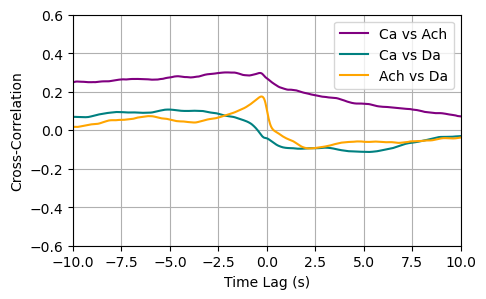

In [16]:
# Calculate the cross correlation between Ca, Ach, and Da

from scipy.signal import correlate

# Calculate the cross-correlation between Ca and Ach
cross_corr_Ca_Ach = correlate(Ca_F2, Ach_F2, mode='full')
n = len(Ca_F2)
cross_corr_Ca_Ach = cross_corr_Ca_Ach / n
# Calculate the cross-correlation between Ca and Da
cross_corr_Ca_Da = correlate(Ca_F2, Da_F2, mode='full')
n = len(Ca_F2)
cross_corr_Ca_Da = cross_corr_Ca_Da / n
# Calculate the cross-correlation between Ach and Da
cross_corr_Ach_Da = correlate(Ach_F2, Da_F2, mode='full')
n = len(Ach_F2)
cross_corr_Ach_Da = cross_corr_Ach_Da / n

# Plot the cross-correlation results over time lags
plt.figure(figsize=(5, 3))
# Create a time vector for the cross-correlation results
lags = np.arange(-len(cross_corr_Ca_Ach)//2+1, len(cross_corr_Ca_Ach)//2+1)
delta_t = 1 / 30.05  # Sampling interval
lag_times = lags * delta_t
plt.plot(lag_times, cross_corr_Ca_Ach, label='Ca vs Ach', color='purple')
lags = np.arange(-len(cross_corr_Ca_Da)//2+1, len(cross_corr_Ca_Da)//2+1)
lag_times = lags * delta_t
plt.plot(lag_times, cross_corr_Ca_Da, label='Ca vs Da', color='teal')
lags = np.arange(-len(cross_corr_Ach_Da)//2+1, len(cross_corr_Ach_Da)//2+1)
lag_times = lags * delta_t
plt.plot(lag_times, cross_corr_Ach_Da, label='Ach vs Da', color='orange')
plt.xlabel('Time Lag (s)')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.xlim(-10, 10)
plt.ylim(-0.6, 0.6)
plt.show()




In [17]:
# # Load TTL file and timestamp csv from NIDAQ

# TTL_file = glob.glob(os.path.join(paths['raw_data'],'TTL*'))
# print(TTL_file)

# # Timestamp for TTL    
# with open(TTL_file[1]) as f:
#     reader = csv.reader(f)
#     datatemp = np.array([row for row in reader])
#     TTLts = datatemp[0:,:].astype(np.float32)

# TTL_signal = np.fromfile(TTL_file[0])

# # Split the TTL signal into its individual sources
# TTL_signal1 = TTL_signal[0::3] # Camera timing signal
# TTL_signal2 = TTL_signal[1::3] # Teensy trigger signal
# TTL_signal3 = TTL_signal[2::3] # Harp behavior signal

# # Binarize the TTL signal
# TTL_signal1 = np.where(TTL_signal1 > 3, 1, 0)
# TTL_signal2 = np.where(TTL_signal2 > 3, 1, 0)
# TTL_signal3 = np.where(TTL_signal3 > 1, 1, 0)


In [18]:
# # Find the time stamps of the camera frames

# def get_rising_edges_and_lengths(signal):
#     """
#     Get the indices of rising edges and the lengths of the high (1) periods in a TTL signal.

#     Parameters:
#     signal (list or np.array): The binary TTL signal (0s and 1s).

#     Returns:
#     np.array: Indices of rising edges.
#     np.array: Lengths of the high (1) periods.
#     """
#     # Ensure the input signal is a numpy array
#     signal = np.array(signal)
#     # Find the difference between consecutive elements
#     diff = np.diff(signal)
#     # Rising edges are where the difference is 1 (0 -> 1 transition)
#     rising_edges = np.where(diff == 1)[0] + 1  # Add 1 to match original index
#     # Falling edges are where the difference is -1 (1 -> 0 transition)
#     falling_edges = np.where(diff == -1)[0] + 1  # Add 1 to match original index
#     # Handle the case where the signal ends with a high level (i.e., no falling edge at the end)
#     if signal[-1] == 1:
#         falling_edges = np.append(falling_edges, len(signal))
#     # Calculate the lengths of the high periods
#     high_lengths = falling_edges - rising_edges

#     return rising_edges, falling_edges, high_lengths

# def upsample_timestamps(timestamps, data_length, downsample_factor=1000):
#     """
#     Upsamples the timestamp vector to match the length of the data vector.

#     Parameters:
#     timestamps (list or np.array): The downsampled timestamps (1 value for every 1000 data points).
#     data_length (int): The length of the data vector.
#     downsample_factor (int): The downsampling factor, default is 1000 (timestamps every 1000 data points).

#     Returns:
#     np.array: The upsampled timestamp vector.
#     """
#     # Generate the original downsampled indices (one timestamp for every downsample_factor data points)
#     original_indices = np.arange(0, data_length, downsample_factor)
#     # Create an array of indices for the full data length
#     full_indices = np.arange(data_length)
#     # Perform linear interpolation to upsample the timestamps
#     interpolation_function = interp1d(original_indices, timestamps, kind='linear', fill_value="extrapolate")
#     # Apply the interpolation function to get timestamps for each data point
#     upsampled_timestamps = interpolation_function(full_indices)
    
#     return upsampled_timestamps

# # Get rising edges and lengths of high periods
# TTL_signal1_rising, TTL_signal1_falling, TTL_signal1_lengths = get_rising_edges_and_lengths(TTL_signal1)

# # Get rising edges that have length between 19 and 21
# TTL_signal1_rising = TTL_signal1_rising[TTL_signal1_lengths >= 19]
# TTL_signal1_lengths = TTL_signal1_lengths[TTL_signal1_lengths >= 19]
# TTL_signal1_rising = TTL_signal1_rising[TTL_signal1_lengths <= 21]
# TTL_signal1_lengths = TTL_signal1_lengths[TTL_signal1_lengths <= 21]

# # Upsample the timestamps
# upsampled_timestamps = upsample_timestamps(TTLts[:,0], len(TTL_signal1), downsample_factor=1000)



In [19]:
# # Digitize the harp analog signal

# def digitize_signal(signal, timestamps, threshold):
#     # Determine transitions based on the threshold
#     high = signal > threshold
#     transitions = np.diff(high.astype(int))
    
#     # Find the indices of transition points
#     low_to_high_indices = np.where(transitions == 1)[0] + 1  # Low to High transition (0 -> 1)
#     high_to_low_indices = np.where(transitions == -1)[0] + 1  # High to Low transition (1 -> 0)
    
#     # Store the transitions with timestamps and types
#     transition_points = {
#         "timestamp": [],
#         "transition": []  # 1 for low->high, 0 for high->low
#     }
    
#     for idx in low_to_high_indices:
#         transition_points["timestamp"].append(timestamps[idx])
#         transition_points["transition"].append(1)  # Low to High
    
#     for idx in high_to_low_indices:
#         transition_points["timestamp"].append(timestamps[idx])
#         transition_points["transition"].append(0)  # High to Low
    
#     return transition_points

# transition_points = digitize_signal(TTL_signal3, upsampled_timestamps, 0.5)

# # Sort the transitions and timestamps
# sorted_indices = np.argsort(transition_points["timestamp"])
# sorted_timestamps = np.array(transition_points["timestamp"])[sorted_indices]
# sorted_transitions = np.array(transition_points["transition"])[sorted_indices]


In [20]:
# # Plot the transitions

# plt.figure(figsize=(8,3))
# plt.plot(upsampled_timestamps, TTL_signal3)
# plt.scatter(transition_points["timestamp"], np.ones(len(transition_points["timestamp"])), c=transition_points["transition"], cmap='coolwarm')
# plt.xlim(upsampled_timestamps[0], upsampled_timestamps[6500])
# plt.show()

# plt.figure(figsize=(8,3))
# plt.plot(sorted_timestamps)
# plt.show()


In [21]:
# # Read harp barcode collected on nidaq

# import numpy as np
# import warnings

# def align_timestamps_to_anchor_points(timestamps_to_align, start_times, anchor_times):
#     """
#     Aligns a set of timestamps to anchor points (e.g., Harp clock times)

#     We assume these timestamps are acquired by a system that is
#     not aligned to the Harp clock. This function finds the nearest
#     anchor point in the Harp clock for each timestamp, and then
#     interpolates between the anchor points to align the timestamps.

#     `decode_harp_clock` must be run first, in order to find the
#     start of each second in the Harp clock.

#     Parameters
#     ----------
#     timestamps_to_align : np.array
#         Local timestamps (in seconds) to align to the Harp clock
#     start_times : np.array
#         Local start times of each second in the Harp clock
#         (output by `decode_harp_clock`)
#     anchor_times : np.array
#         Global clock times in seconds (typically the Harp clock times,
#         but can be any set of anchor points to align to)
#         (output by `decode_harp_clock`)

#     Returns
#     -------
#     aligned_times : np.array
#         Aligned timestamps
#     """

#     if len(start_times) != len(anchor_times):
#         raise ValueError(
#             "The number of start times must equal the number of Harp times"
#         )

#     N = len(start_times)

#     slopes = np.zeros((N + 1,))
#     offsets = np.zeros((N + 1,))

#     # compute overall slope and offset
#     A = np.vstack([start_times, np.ones(len(start_times))]).T
#     slopes[0], offsets[0] = np.linalg.lstsq(A, anchor_times, rcond=None)[0]

#     # compute slope and offset for each segment
#     for i in range(N):
#         x = start_times[i : i + 2]
#         y = anchor_times[i : i + 2]
#         A = np.vstack([x, np.ones(len(x))]).T
#         slopes[i + 1], offsets[i + 1] = np.linalg.lstsq(A, y, rcond=None)[0]

#     # find the nearest anchor point for each timestamp to align
#     nearest = np.searchsorted(start_times, timestamps_to_align, side="left")

#     nearest[nearest == N] = 0

#     # interpolate between the anchor points
#     aligned_times = timestamps_to_align * slopes[nearest] + offsets[nearest]

#     return aligned_times


# def decode_harp_clock(timestamps, states, baud_rate=1000.0):
#     """
#     Decodes Harp clock times (in seconds) from a sequence of local
#     event timestamps and states.

#     The Harp Behavior board can be configured to output a digital
#     signal that encodes the current Harp time as a 32-bit integer,
#     which is emitted once per second.

#     The format of the signal is as follows:

#       Default value: high
#       Start bit: low -- indicates the transition to the next second
#       8 bits: byte 0, with least significant bit first
#       2 bits: high / low transition
#       8 bits: byte 1, with least significant bit first
#       2 bits: high / low transition
#       8 bits: byte 2, with least significant bit first
#       2 bits: high / low transition
#       8 bits: byte 3, with least significant bit first
#       Final bit: reset to high

#     Although the baud rate of the internal Harp clock is
#     100 kHz, the Behavior board outputs the clock signal
#     at a lower baud rate (typically 1 kHz), so it can be
#     acquired by data acquisition systems with sample rates
#     as low as 5 kHz.

#     Parameters
#     ----------
#     timestamps : np.array
#         Float times in seconds for each clock line transition
#         If the acquisition system outputs integer sample numbers
#         for each event, divide by the sample rate to convert to seconds
#     states : np.array
#         States (1 or 0) for each clock line transition
#     baud_rate : float
#         The baud rate of the Harp clock signal

#     Returns
#     -------
#     start_times : np.array
#         Timestamps at which each second begins
#     harp_times : np.array
#         Harp clock times in seconds
#     """

#     min_delta = 0.5  # seconds -- Harp clock events must always be
#     # at least this far apart

#     barcode_edges = get_barcode_edges(timestamps, min_delta)

#     start_times = np.array([timestamps[edges[0]] for edges in barcode_edges])

#     harp_times = np.array(
#         [
#             convert_barcode(
#                 timestamps[edges[0] : edges[1]],
#                 states[edges[0] : edges[1]],
#                 baud_rate=baud_rate,
#             )
#             for edges in barcode_edges
#         ]
#     )

#     # start_times_corrected, harp_times_corrected = remove_outliers(
#     #     start_times, harp_times
#     # )

#     # return start_times_corrected, harp_times_corrected
#     return start_times, harp_times


# def get_barcode_edges(timestamps, min_delta):
#     """
#     Returns the start and end indices of each barcode

#     Parameters
#     ----------
#     timestamps : np.array
#         Timestamps (ins seconds) of clock line events
#         (high and low states)
#     min_delta : int
#         The minimum length between the end of one
#         barcode and the start of the next

#     Returns
#     -------
#     edges : list of tuples
#         Contains the start and end indices of each barcode
#     """

#     (splits,) = np.where(np.diff(timestamps) > min_delta)

#     return list(zip(splits[:-1] + 1, splits[1:] + 1))


# def convert_barcode(transition_times, states, baud_rate):
#     """
#     Converts Harp clock barcode to a clock time in seconds

#     Parameters
#     ----------
#     transition_times : np.array
#         Times (in seconds) each clock line transition
#     states : np.array
#         states (1 or 0) for each clock line transition
#     baud_rate : float
#         The baud rate of the clock signal

#     Returns
#     -------
#     harp_time : int
#         Harp time in seconds for the current barcode

#     """

#     intervals = np.round(np.diff(transition_times * baud_rate)).astype("int")

#     barcode = np.concatenate(
#         [np.ones((count,)) * state for state, count in zip(states[:-1], intervals)]
#     ).astype("int")

#     val = np.concatenate(
#         (np.arange(1, 9), np.arange(11, 19), np.arange(21, 29), np.arange(31, 39))
#     )

#     s = np.flip(barcode[val])
#     harp_time = s.dot(2 ** np.arange(s.size)[::-1])

#     return harp_time


# def remove_outliers(start_times, harp_times):
#     """
#     Removes outliers from the Harp clock times

#     These outliers are caused by problems decoding
#     the Harp clock signal, leading to consecutive times that
#     do not increase by exactly 1. These will be removed from
#     the array of Harp times, so they will not be used
#     as anchor points during subsequent clock alignment.

#     If the times jump to a new value and continue to
#     increase by 1, either due to a reset of the Harp clock
#     or a gap in the data, these will be ignored.

#     Parameters
#     ----------
#     start_times : np.array
#         Harp clock start times in seconds
#     harp_times : np.array
#         Harp clock times in seconds

#     Returns
#     -------
#     corrected_start_times : np.array
#         Corrected Harp clock times in seconds
#     corrected_harp_times : np.array
#         Corrected Harp clock times in seconds
#     """

#     original_indices = np.arange(len(harp_times))

#     new_indices = np.concatenate(
#         [
#             sub_array
#             for sub_array in np.split(
#                 original_indices, np.where(np.diff(harp_times) != 1)[0] + 1
#             )
#             if len(sub_array) > 1
#         ]
#     )

#     num_outliers = len(original_indices) - len(new_indices)

#     if num_outliers > 0:
#         warnings.warn(
#             f"{num_outliers} outlier{'s' if num_outliers > 1 else ''} "
#             + "found in the decoded Harp clock. Removing..."
#         )

#     return start_times[new_indices], harp_times[new_indices]

# start_times, harp_times = decode_harp_clock(sorted_timestamps/1000, sorted_transitions, baud_rate=1000.0)

In [22]:
# # Convert hsfp time to harp time

# def upsample_timestamps(timestamps, data_length, downsample_factor=1000):
#     """
#     Upsamples the timestamp vector to match the length of the data vector.

#     Parameters:
#     timestamps (list or np.array): The downsampled timestamps (1 value for every 1000 data points).
#     data_length (int): The length of the data vector.
#     downsample_factor (int): The downsampling factor, default is 1000 (timestamps every 1000 data points).

#     Returns:
#     np.array: The upsampled timestamp vector.
#     """
#     # Generate the original downsampled indices (one timestamp for every downsample_factor data points)
#     original_indices = np.arange(0, data_length, downsample_factor)
#     # Create an array of indices for the full data length
#     full_indices = np.arange(data_length)
#     # Perform linear interpolation to upsample the timestamps
#     interpolation_function = interp1d(original_indices, timestamps, kind='linear', fill_value="extrapolate")
#     # Apply the interpolation function to get timestamps for each data point
#     upsampled_timestamps = interpolation_function(full_indices)
    
#     return upsampled_timestamps

# # Upsample the timestamps
# hsfp_timestamps = upsample_timestamps(start_times, len(start_times)*1000, downsample_factor=1000)
# harp_timestamps = upsample_timestamps(harp_times, len(harp_times)*1000, downsample_factor=1000)

# # Convert each laser hsfp time to harp time

# def convert_hsfp_to_harp_time(hsfp_timestamps, harp_timestamps, hsfp_time):
#     """
#     Converts HSFP timestamps to Harp timestamps.
#     Parameters:
#     hsfp_timestamps (np.array): The HSFP timestamps.
#     harp_timestamps (np.array): The Harp timestamps.
#     hsfp_time (float): The HSFP time to convert.
#     Returns:
#     float: The Harp time.
#     """
#     harp_time = np.zeros(len(hsfp_time))
#     for i in range(len(hsfp_time)):
#         # Find the index of the closest HSFP timestamp
#         hsfp_index = np.searchsorted(hsfp_timestamps, hsfp_time[i])
#         harp_time[i] = harp_timestamps[hsfp_index]
#     return harp_time

# # Convert each laser hsfp time to harp time
# harp_time_405 = convert_hsfp_to_harp_time(hsfp_timestamps, harp_timestamps, time_405)
# harp_time_445 = convert_hsfp_to_harp_time(hsfp_timestamps, harp_timestamps, time_445)
# harp_time_473 = convert_hsfp_to_harp_time(hsfp_timestamps, harp_timestamps, time_473)
# harp_time_514 = convert_hsfp_to_harp_time(hsfp_timestamps, harp_timestamps, time_514)
# harp_time_560 = convert_hsfp_to_harp_time(hsfp_timestamps, harp_timestamps, time_560)
